In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import datetime
import joblib

In [3]:
file_path = 'car-manual-dataset/simulation-dataset-sample.csv'
df = pd.read_csv(file_path)
#load a mannually generated dataset

print("Load dateset successful")
#df.info()
print("\nShowing first 5 lines:")
print(df.head())

Load dateset successful

Showing first 5 lines:
   run_id  time_step    d_front     d_back   v_front    v_back  ego_a
0       0          0  50.178533  25.089267  0.000000  0.000000    0.0
1       0          1  50.165721  25.102079 -0.256249  0.256249    1.5
2       0          2  50.137552  25.130247 -0.307118  0.307118    1.5
3       0          3  50.089358  25.178441 -0.656761  0.656761    1.5
4       0          4  50.027604  25.240195 -0.578324  0.578324    1.5


In [4]:
def classify_acceleration(a, threshold=0.05):
    if a > threshold:
        return 2  # speed up
    elif a < -threshold:
        return 0  # slow down
    else:
        return 1  # stay

# transfer the acceleration from -1.5, 0, 1.5 to class 0,1,2
df['action'] = df['ego_a'].apply(classify_acceleration)
print(df['action'].value_counts())

#define model input and output
FEATURE_COLUMNS = ['d_front', 'd_back', 'v_front', 'v_back']
LABEL_COLUMN = 'action'

X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24,stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"TrainSet scale: {len(X_train_scaled)}")
print(f"TestSet scale: {len(X_test_scaled)}")

action
0    2275
2    2230
1     488
Name: count, dtype: int64
TrainSet scale: 3994
TestSet scale: 999


In [5]:
# Simply using Katya's code, with output layer changed
def get_model(input_size, num_classes):

    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    
    model = Sequential([
            Input(shape=(input_size,), name='input_features'),
            Dense(32, activation='relu', kernel_initializer=initializer, name='dense_1'),
            Dense(num_classes, activation='softmax', kernel_initializer=initializer, name='output_layer')
        ])
    
    return model

In [6]:
# Train the model
num_classes = len(np.unique(y_train))
input_size = X_train_scaled.shape[1]
train_dataset = X_train_scaled
epochs = 3


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size, num_classes)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(
    train_dataset,
    y_train, 
    epochs=epochs, 
    batch_size = 32,
    validation_data=(X_test_scaled, y_test))


Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.8855 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.5839 - val_sparse_categorical_accuracy: 0.8879
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.4399 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.9019
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.2858 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.9029


In [7]:
# Visalization, copied from Katya
def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    # Binarize the output (needed for multiclass ROC)
    # This turns the class labels into a one-vs-rest binary format
    y_test_bin = label_binarize(y, classes=np.arange(c))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
Precision (macro): 0.9352
Recall (macro): 0.6701
F1-score (macro): 0.6393


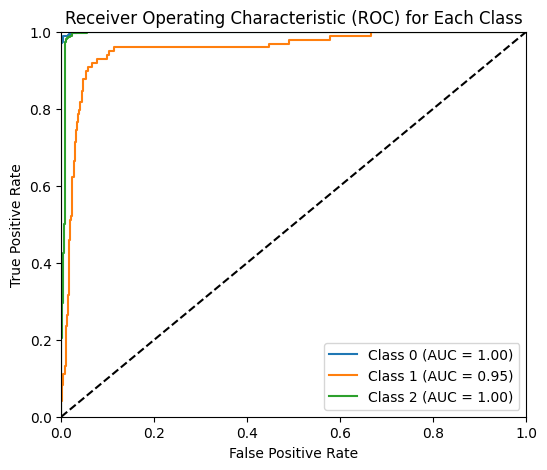

In [8]:
print_metrics(model_base, X_test_scaled, y_test, num_classes)

In [12]:
# Save the trained model, if you like
model_folder = 'nn-models'
os.makedirs(model_folder, exist_ok=True)
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'nn_model_{timestamp_str}.keras'
model_path = os.path.join(model_folder, model_filename)
scaler_path = os.path.join(model_folder,'scaler.pkl')
joblib.dump(scaler,scaler_path)
# model_base.save(model_path)
# print(f"model saved to {model_path}")




['nn-models/scaler.pkl']